### Step 1
Import the relevant packages and collect all the necessary dependencies.

In [21]:
import os, sys
import math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.figure import Figure
from typing import List, Dict
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [22]:
# Display the version of tensorflow, sklearn, and the GPU
print(f'Python: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'TensorFlow: {tensorflow.__version__}')
print(f'Keras: {tensorflow.keras.version()}')
print(f'Scikit-learn: {sklearn.__version__}')
gpus = tensorflow.config.list_physical_devices('GPU')
print(f'GPUs: {gpus if gpus else "None"}')

Python: 3.10.13
TensorFlow: 2.15.0
Keras: 3.2.1
Scikit-learn: 1.2.2
GPUs: None


### Step 2
Upload and import the data.  

_While loading the images, they're also converted to `.png` files, since `.pgm` is not directly supported by the [keras image loading APIs](https://keras.io/api/data_loading/image/)._

In [23]:
data_path = '/kaggle/input/att-database-of-faces'  # Set this to the correct path for each environment.  On Kaggle, this would be '/kaggle/input/att-database-of-faces'
work_path = '/kaggle/working'  # Set this to the correct path for each environment.  On Kaggle, this would be '/kaggle/working'

In [24]:
def load_images(src_folder: str, work_folder: str, sub_folder_prefix: str, file_extension: str) -> pd.DataFrame:
    images = []
    labels = []
    if not os.path.exists(work_folder):
        os.makedirs(work_folder)
    for lbl in [int(lbl[1:]) for lbl in os.listdir(src_folder) if lbl.startswith(sub_folder_prefix)]:
        lbl_dir = f'{src_folder}/{sub_folder_prefix}{lbl}'
        if not os.path.exists(lbl_dir.replace(src_folder, work_folder)):
            os.makedirs(lbl_dir.replace(src_folder, work_folder))
        for img in [img for img in os.listdir(lbl_dir) if img.endswith(file_extension)]:
            img_path = f'{lbl_dir}/{img}'
            img = Image.open(img_path)
            new_path = img_path.replace(file_extension, '.png').replace(src_folder, work_folder)
            img.save(new_path)
            images.append(new_path)
            labels.append(f'{lbl:02d}')
    return pd.DataFrame({'image': images, 'label': labels})

In [25]:
# Load the images
df = load_images(data_path, work_path, 's', '.pgm')

# Summarize the images
img_arr = np.array([Image.open(img) for img in df['image']])
print('Image shape(s) and corresponding count(s):')
print(pd.Series([i.shape for i in img_arr]).value_counts().to_string(index=True))
print('\nMin/Max pixel value(s) over all images:')
print(f'{img_arr.min()}, {img_arr.max()}')
print('\nCounts of images for each label:')
print(pd.Series(df["label"].value_counts()).sort_index().to_frame().T.to_string(index=True))

Image shape(s) and corresponding count(s):
(112, 92)    400

Min/Max pixel value(s) over all images:
0, 251

Counts of images for each label:
label  01  02  03  04  05  06  07  08  09  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
count  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10


### Step 3
View a few images to get a sense of the data.

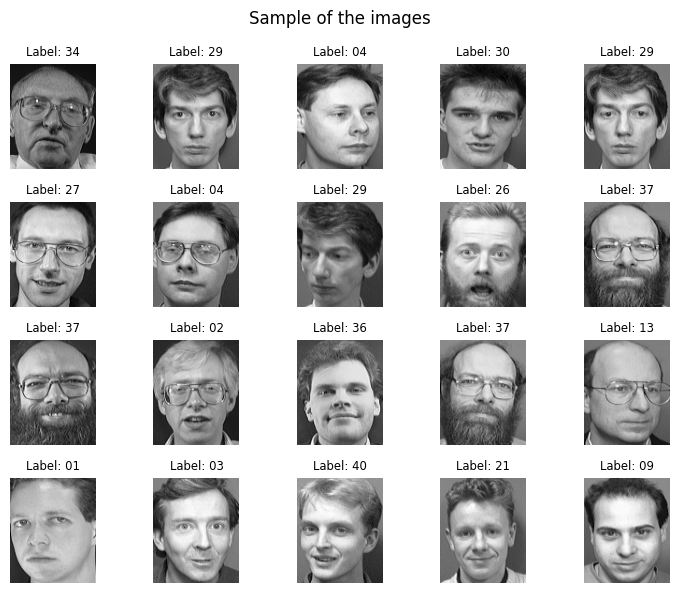

In [26]:
def display_images(df: pd.DataFrame, pct: int, title: str) -> None:
    num_images = math.ceil(len(df) * pct / 100.0)
    img_per_row = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / img_per_row)
    plt.figure(figsize=(img_per_row*1.5, rows*1.5))
    plt.suptitle(title)
    picked_image_indexes = []
    for i in range(num_images):
        idx = None
        while (idx is None or idx in picked_image_indexes):
            idx = np.random.randint(0, df.shape[0])
        picked_image_indexes.append(idx)
    for i in range(img_per_row * rows):
        plt.subplot(rows, img_per_row, i+1)
        plt.imshow(Image.open(df['image'].iloc[picked_image_indexes[i]]), cmap='gray')
        plt.title(f"Label: {df['label'].iloc[picked_image_indexes[i]]}", fontsize='small')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of the images
display_images(df, 5, 'Sample of the images')

### Step 4  
Create a validation framework and split the data into train, test, and validation datasets.  
_We'll use a 60/20/20 percent split for training/validation/test: the dataset is so small that we need to have at least 20% for each of testing and validation. Data augmentation will be used for the training and validation datasets to reduce overfitting._

In [27]:
def train_val_test_split(df: pd.DataFrame, test_size: float, val_size: float, random_state: int=42) -> tuple:
    true_val_size = val_size / (1 - test_size)
    X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=test_size, random_state=random_state, stratify=df['label'])
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=true_val_size, random_state=random_state, stratify=y_train)
    return pd.DataFrame({'image': X_train, 'label': y_train}), pd.DataFrame({'image': X_val, 'label': y_val}), pd.DataFrame({'image':X_test, 'label': y_test})

In [28]:
df_train, df_val, df_test = train_val_test_split(df, test_size=0.2, val_size=0.2)

# Show the size of each set
print(f'Training set size: {len(df_train)}')
print(f'Validation set size: {len(df_val)}')
print(f'Testing set size: {len(df_test)}')

Training set size: 240
Validation set size: 80
Testing set size: 80


### Step 5  
Perform necessary transformations to prepare the data for input to the CNN model.  
Notes:
* All images are normalized to 0-1 for the single (grayscale) channel  
* Both the training and validation datasets are augmented in ways that should correspond to faces of people standing upright using:  
  * zoom (+/- 20%)
  * rotation (+/- 5 degrees)
  * width and height shift (+/- 10%)
  * brightness shift (+/- 20%)
  * horizontal flip
* Since all images are small and consistent in size (112x92), no resizing is done

In [29]:
def build_dataset(gen: ImageDataGenerator, df: pd.DataFrame, shuffle: bool=False, batch_size: int=64):
    return gen.flow_from_dataframe(
        df,
        x_col='image',
        y_col='label',
        target_size=(112, 92),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle)

def build_aug_generator() -> ImageDataGenerator:
    return ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8,1.2],
        horizontal_flip=True,
        fill_mode='nearest')

train_datagen = build_aug_generator()
train_ds = build_dataset(train_datagen, df_train, shuffle=True)

val_datagen = build_aug_generator()
val_ds = build_dataset(val_datagen, df_val)

test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = build_dataset(test_datagen, df_test, batch_size=1)

Found 240 validated image filenames belonging to 40 classes.
Found 80 validated image filenames belonging to 40 classes.
Found 80 validated image filenames belonging to 40 classes.


### Step 6  
Build a CNN model with three main layers: a convolutional layer, a pooling layer, and a fully connected layer. You can also consider utilizing state-of-the-art architectures using transfer learning.  

_This is a very small dataset with reduced information: all images use a single channel, and they all correspond to adult faces looking almost straight at the camera. Existing CNNs may hence be 'overkill' for this simple task._

In [30]:
# Build a simple CNN model using Keras to classify the images
def build_model(input_shape: tuple, num_classes: int) -> Sequential:
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax'),
        Dropout(0.2)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])
    return model

In [31]:
model = build_model((112, 92, 1), 40)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 110, 90, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 55, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 53, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,769,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,867,432 (7.12 MB)

 Trainable params: 1,867,432 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

_Note: Data augmentation is being used, early stopping is therefore being implemented to ensure proper maximization of the weights.  Because the model is so small, though, a large patience (50)_

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, start_from_epoch=100, verbose=1)

_Note: Because random data augmentation is being used, there is a possibility the model will oscillate around the optimum. Learning rate reduction is added to help reduce this effect._

In [33]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1, min_lr=1e-6)

### Step 7  
Train the model using the prepared data.

In [34]:
import warnings
warnings.filterwarnings('ignore', message='.*Your `PyDataset` class should call.*')

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=[early_stopping, reduce_lr], verbose=2)

Epoch 1/1000
4/4 - 6s - 2s/step - accuracy: 0.0292 - f1_score: 0.0099 - loss: 5.7550 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0250 - val_f1_score: 0.0016 - val_loss: 3.6900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 2/1000
4/4 - 3s - 732ms/step - accuracy: 0.0208 - f1_score: 0.0066 - loss: 5.6354 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0250 - val_f1_score: 0.0012 - val_loss: 3.6854 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 3/1000
4/4 - 3s - 741ms/step - accuracy: 0.0333 - f1_score: 0.0120 - loss: 5.6856 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0250 - val_f1_score: 0.0013 - val_loss: 3.6836 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 4/1000
4/4 - 3s - 797ms/step - accuracy: 0.0250 - f1_score: 0.0059 - loss: 6.2535 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0250 - val_f1_s

### Step 8
  
Plot the results to evaluate the model's performance.

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


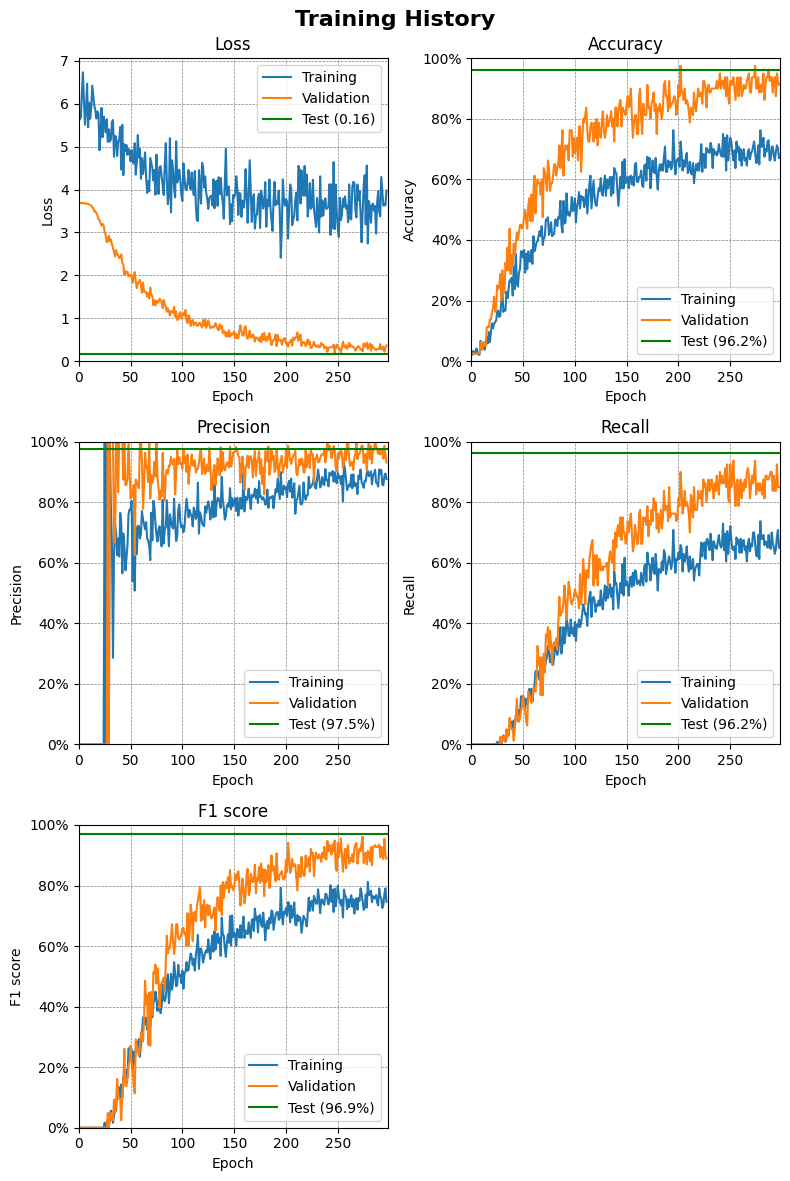

In [35]:
def f1(prec_list: List[float], rec_list: List[float]):
    retval = []
    for i in range(len(prec_list)):
        prec = prec_list[i]
        rec = rec_list[i]
        retval.append( 2 * (prec * rec) / (prec + rec) if prec + rec != 0 else 0)
    return retval

def quality_scores(model: Model, generator: ImageDataGenerator) -> Dict[str, float]:
    pred = model.predict(generator)
    pred_labels = np.argmax(pred, axis=1) # Turn "one-hot encoding"-like probabilities into integer encoding for easier comparison with true labels
    retval = {}
    retval['accuracy'] = accuracy_score(generator.labels, pred_labels)
    retval['precision'] = precision_score(generator.labels, pred_labels, average='macro', zero_division=0)
    retval['recall'] = recall_score(generator.labels, pred_labels, average='macro')
    retval['f1_score'] = 2 * (retval['precision'] * retval['recall']) / (retval['precision'] + retval['recall'])
    loss_func = tensorflow.keras.losses.SparseCategoricalCrossentropy()
    retval['loss'] = loss_func(np.array(generator.labels), pred)
    return retval

def training_subplot(hist, metric: str, plotnum: int, lim = None, test_val = None):
    sp = plt.subplot(3, 2, plotnum)
    metric_nm = metric.replace('_',' ').capitalize()
    plt.plot(hist.history[metric], label='Training')
    plt.plot(hist.history['val_' + metric], label='Validation')
    if (test_val is not None):
        test_lbl = 'Test ' + (f'({test_val:.1%})' if (lim == 1) else f'({test_val:.2f})')
        plt.axhline(y=test_val, label=test_lbl, color='green', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel(metric_nm)
    plt.ylim(0, lim)
    plt.xlim(0, len(hist.history['loss']))
    if (lim == 1):
        sp.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='grey')
    plt.title(metric_nm)

def training_plot(hist, model: Model, generator: ImageDataGenerator, title='Training History'):
    quality = quality_scores(model, generator)
    # Plot the training history (loss and accuracy) in two subplots
    plt.figure(figsize=(8, 12))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    training_subplot(hist, 'loss', 1, test_val=quality['loss'])
    training_subplot(hist, 'accuracy', 2, 1, test_val=quality['accuracy'])
    training_subplot(hist, 'precision', 3, 1, test_val=quality['precision'])
    training_subplot(hist, 'recall', 4, 1, test_val=quality['recall'])
    training_subplot(hist, 'f1_score', 5, 1, test_val=quality['f1_score'])
    plt.tight_layout()
    plt.show()

history.history['f1_score'] = f1(history.history['precision'], history.history['recall'])
history.history['val_f1_score'] = f1(history.history['val_precision'], history.history['val_recall'])
training_plot(history, model, test_ds, "Training History")

### Step 9

Iterate on the model, making adjustments and improvements, until you achieve an accuracy above 90%.

_This was done offline_

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


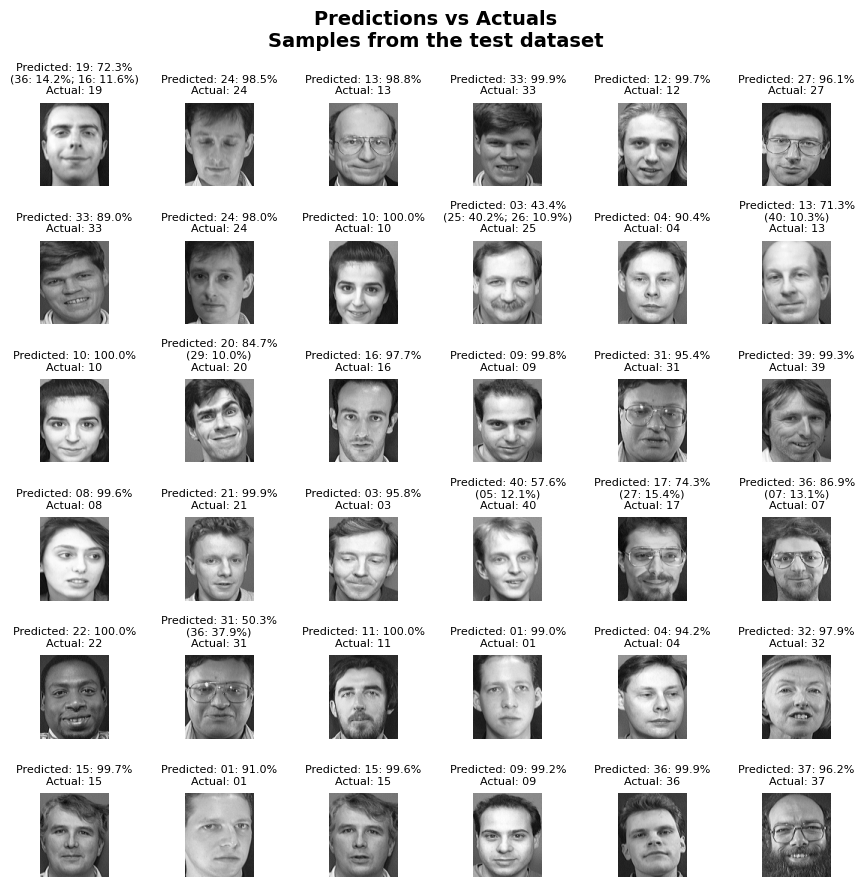

In [36]:
def predict_and_display(model: Model, generator: ImageDataGenerator):
    pred = model.predict(generator)
    class_names = [k for k in generator.class_indices.keys()]

    plt.figure(figsize=(9, 9))
    plt.suptitle('Predictions vs Actuals\nSamples from the test dataset', fontsize=14, fontweight='bold')
    picked_image_indexes = []
    for i in range(36):
        # pick a random image index that hasn't been picked yet
        idx = None
        while (idx is None or idx in picked_image_indexes):
            idx = np.random.randint(0, len(generator.filenames))
        picked_image_indexes.append(idx)
        # Show top probability(ies) greater than 10%
        top_preds = [(str(k), f"{round(float(v),3):.1%}") for k, v in zip(generator.class_indices.keys(), pred[idx]) if v >= 0.1]
        top_preds.sort(key=lambda x: x[1], reverse=True)
        top_pred_str = f"{top_preds[0][0]}: {top_preds[0][1]}"
        if (len(top_preds) > 1):
            top_pred_str += "\n(" + "; ".join([f"{k}: {v}" for k, v in top_preds[1:]]) + ")" 
        # Show image
        ax = plt.subplot(6, 6, i+1)
        plt.imshow(plt.imread(generator.filenames[idx]), cmap='gray')
        plt.title(f"Predicted: {top_pred_str}\nActual: {class_names[generator.labels[idx]]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

predict_and_display(model, test_ds)

In [37]:
# Save the model
model.save('./model.keras')

In [38]:
def predict(model: Model, generator: ImageDataGenerator, threshold: float=0.1):
    pred = model.predict(generator)
    ret_labels = np.argmax(pred, axis=1)
    ret_class_names = [k for k in generator.class_indices.keys()]
    ret_top_preds = [[(int(k), f"{round(float(v),3):.1%}") for k, v in zip(ret_class_names, pred[i]) if v >= threshold] for i in range(len(pred))]
    for p in ret_top_preds:
        p.sort(key=lambda x: x[1], reverse=True)
    return ret_labels, ret_class_names, ret_top_preds

pred_labels, class_names, top_preds = predict(model, test_ds)
top_preds_str = [f"; ".join([f"{k}: {v}" for k, v in p]) for p in top_preds]
mispreds = []
for i, (p, a) in enumerate(zip(pred_labels, test_ds.labels)):
    if p != a:
        mispreds.append({'predicted': int(class_names[p]), 'actual': int(class_names[a]), 'file': test_ds.filenames[i], 'probs': top_preds_str[i]})
mispreds.sort(key=lambda x: x['actual'])

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


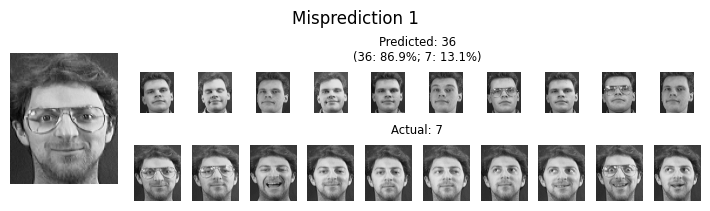

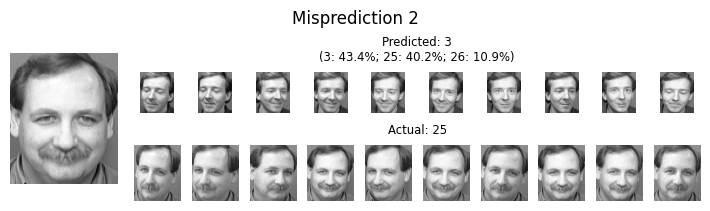

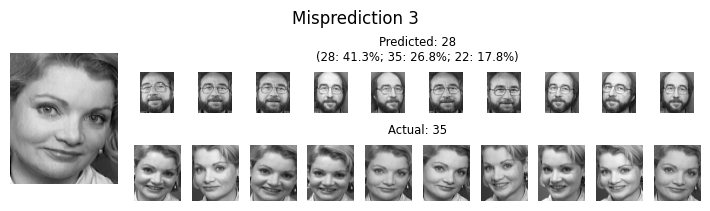

In [39]:
def show_label_images(fig: Figure, label: int, path: str, prefix: str, title: str) -> None:
    imgs_to_show = [f for f in os.listdir(f'{path}/{prefix}{label}') if f.endswith('.png')]
    for i, img in enumerate(imgs_to_show):
        sp = fig.add_subplot(1, len(imgs_to_show), i+1)
        sp.imshow(plt.imread(f'{path}/{prefix}{label}/{img}'), cmap='gray')
        sp.axis('off')
    fig.suptitle(title,fontsize='small')

def show_mispred(mispred: dict, mispred_num: int, path: str, prefix: str) -> None:
    f = plt.figure(layout='constrained', figsize=(7,2))
    f.suptitle(f"Misprediction {mispred_num}")
    subfigs = f.subfigures(nrows=1,ncols=2,width_ratios=[2,10])
    ax = subfigs[0].add_subplot(1,1,1)
    ax.imshow(plt.imread(mispred['file']), cmap='gray')
    ax.axis('off')
    subfigs2 = subfigs[1].subfigures(nrows=2,ncols=1)
    show_label_images(subfigs2[0],mispred['predicted'],path, prefix, f"Predicted: {mispred['predicted']}\n({mispred['probs']})")
    show_label_images(subfigs2[1],mispred['actual'],path, prefix,f"Actual: {mispred['actual']}")
    plt.show()

for i, m in enumerate(mispreds):
    show_mispred(m, i+1, work_path, 's')
